<a href="https://colab.research.google.com/github/shizoda/education/blob/main/machine_learning/vae/variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder (VAE)

基本の Autoencoder (AE) が分かったところで、VAE について見ていきましょう。

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# データセットの変換処理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10のトレーニングデータセット
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# CIFAR-10のテストデータセット
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:01<00:00, 88379702.74it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### エンコーダーとデコーダー

AEでは、エンコーダーは入力を直接低次元の潜在空間にマッピングし、デコーダーはその潜在表現を使って入力データを再構成します。

それに対してVAEの場合、エンコーダーは入力データから潜在空間の確率分布のパラメータ（平均と分散）を推定し、デコーダーは潜在空間からサンプリングされた値を使って入力データを再構成します。これにより、データ生成プロセスに確率論的な要素が導入されます。

In [5]:
# VAEの定義
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # エンコーダー
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 400)
        self.fc21 = nn.Linear(400, 20)  # muを出力
        self.fc22 = nn.Linear(400, 20)  # logvarを出力

        # デコーダー
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 32 * 8 * 8)
        self.convtranspose1 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.convtranspose2 = nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))
        x = x.view(-1, 32, 8, 8)
        x = F.relu(self.convtranspose1(x))
        x = torch.sigmoid(self.convtranspose2(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


### 損失関数

AEの損失関数は通常、再構成誤差（例：MSE）のみを考慮します。

それに対してVAEでは、再構成誤差とKLダイバージェンス（エンコーダーによって推定された潜在変数の分布と事前分布との間の差異を表す）の和を損失関数として使用します。

In [6]:
# 損失関数
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [7]:
# モデルのインスタンス化、最適化手法の設定
device = "cuda:0"
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 訓練ループ
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        optimizer.zero_grad()
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(trainloader.dataset)} ({100. * batch_idx / len(trainloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(trainloader.dataset):.4f}')

# 訓練の実行
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(epoch)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1664.817505
Train Epoch: 1 [6400/50000 (13%)]	Loss: 694.230774
Train Epoch: 1 [12800/50000 (26%)]	Loss: 586.974426
Train Epoch: 1 [19200/50000 (38%)]	Loss: 629.404053
Train Epoch: 1 [25600/50000 (51%)]	Loss: 575.109131
Train Epoch: 1 [32000/50000 (64%)]	Loss: 629.353516
Train Epoch: 1 [38400/50000 (77%)]	Loss: 552.704102
Train Epoch: 1 [44800/50000 (90%)]	Loss: 552.952087
====> Epoch: 1 Average loss: 634.0771
Train Epoch: 2 [0/50000 (0%)]	Loss: 617.078979
Train Epoch: 2 [6400/50000 (13%)]	Loss: 605.918091
Train Epoch: 2 [12800/50000 (26%)]	Loss: 559.636353
Train Epoch: 2 [19200/50000 (38%)]	Loss: 603.212891
Train Epoch: 2 [25600/50000 (51%)]	Loss: 550.917725
Train Epoch: 2 [32000/50000 (64%)]	Loss: 470.710114
Train Epoch: 2 [38400/50000 (77%)]	Loss: 596.798218
Train Epoch: 2 [44800/50000 (90%)]	Loss: 549.558716
====> Epoch: 2 Average loss: 543.2047
Train Epoch: 3 [0/50000 (0%)]	Loss: 476.958893
Train Epoch: 3 [6400/50000 (13%)]	Loss: 588.948059
Train

In [8]:
# 訓練が終わったら、いくつかの画像でどのように動作するかを確認
dataiter = iter(testloader)
images, labels = next(dataiter)

output = model(images.cuda())  # CUDAを使用している場合

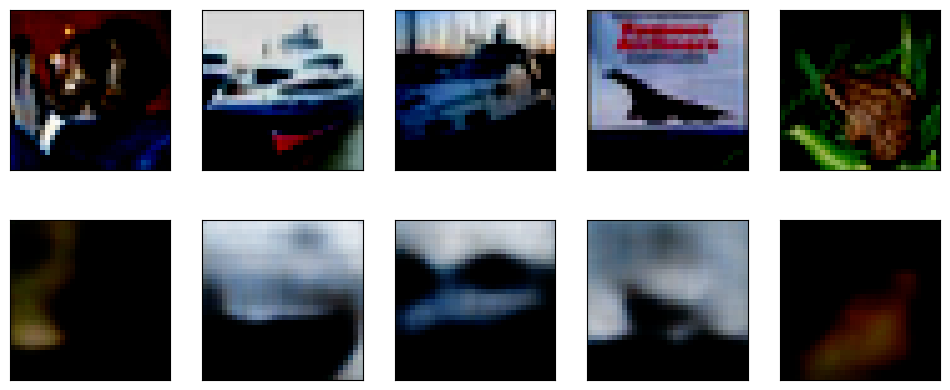

In [18]:
# 訓練が終わったら、いくつかの画像でどのように動作するかを確認
dataiter = iter(testloader)
images, labels = next(dataiter)

output = model(images.to(device))  # CUDAを使用している場合
images = images.numpy()
output = output[0].detach().cpu().numpy()

# 元の画像と再構成された画像を表示
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(12,5))
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

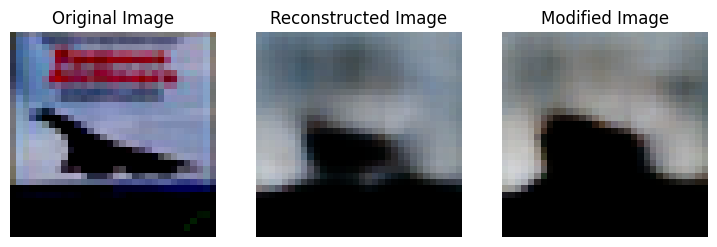

In [10]:
def display_images_with_modification(model, dataloader, index, modification_strength=0.5):
    # 指定されたインデックスのデータを取得
    for i, data in enumerate(dataloader, 0):
        images, _ = data
        if i == index // 64:  # 64はバッチサイズ
            # 指定されたインデックスの画像を選択
            image = images[index % 64].unsqueeze(0)  # バッチ次元を追加
            break

    # 画像をエンコードしてzを取得し、そのままデコード
    mu, logvar = model.encode(image.to("cuda:0"))
    z = model.reparameterize(mu, logvar)
    reconstructed_image = model.decode(z)

    # zに変更を加えてデコード
    z_modified = z + modification_strength * torch.randn_like(z)
    modified_image = model.decode(z_modified)

    # 元の画像、再構成された画像、修正された画像を表示
    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    ax[0].imshow(image.detach().cpu().numpy().transpose(1, 2, 0))
    ax[0].set_title("Original Image")
    ax[1].imshow(reconstructed_image[0].detach().cpu().numpy().transpose(1, 2, 0))
    ax[1].set_title("Reconstructed Image")
    ax[2].imshow(modified_image[0].detach().cpu().numpy().transpose(1, 2, 0))
    ax[2].set_title("Modified Image")

    for a in ax:
        a.axis('off')
    plt.show()

# modelがVAEのインスタンス、testloaderがテストデータのDataLoader
# 例えば、3番目の画像に対して、変更の強さを0.5として実行
display_images_with_modification(model, testloader, 3, 0.5)


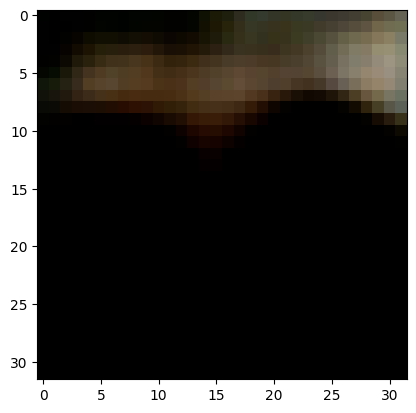

In [17]:
# 標準正規分布からzをサンプリング
z = torch.randn(1, 20).to(device)  # ここでの1はバッチサイズ、20はzの次元

# デコーダーを使ってzから画像を生成
generated_image = model.decode(z)

# 生成した画像を確認
plt.imshow(generated_image.detach().cpu().numpy()[0].transpose(1, 2, 0))
plt.show()